# TPC-H 100 bench reading from EBS

We upload 100GB of TPC-H data to AWS EFS and run some ballista queries on AWS Fargate.

In [1]:
import os

region_name="us-east-1"
aws_profile=os.environ["AWS_PROFILE"] # Specify the profile you want to use from your .aws/credentials file with the AWS_PROFILE env variable
lambda_name="ballista-aws-tools-trigger-dev"

MEGA = 1024*1024

In [2]:
import boto3
from botocore.config import Config

import json
import base64
from datetime import datetime
import time
import pandas as pd

my_config = Config(
    region_name = region_name,
    read_timeout = 900,
    retries = {
        'max_attempts': 1,
    }
)

session = boto3.Session(profile_name=aws_profile)
client = session.client('lambda', config = my_config)

Run the TPC-H query 1 (group by on line items) with a number of executors ranging from 4 to 12:

In [9]:
durations = []
tpch_query = 1
for exec_count in range(4,13):
    inputParams = {
        "executor_count": exec_count,
        "tpch_query": tpch_query,
    }
    response = client.invoke(
        FunctionName = lambda_name,
        InvocationType = 'RequestResponse',
        Payload = json.dumps(inputParams),
        LogType='Tail'
    )
    # print(base64.b64decode(response['LogResult']).decode("utf-8"))
    resp_body = json.load(response['Payload'])
    durations.append({
        'executor_count': exec_count,
        'tpch_query': tpch_query,
        'provisioning_duration_ms': resp_body['provisioning_duration_ms'],
        'execution_duration_ms': resp_body['execution_duration_ms'],
    })

<AxesSubplot:xlabel='executor_count'>

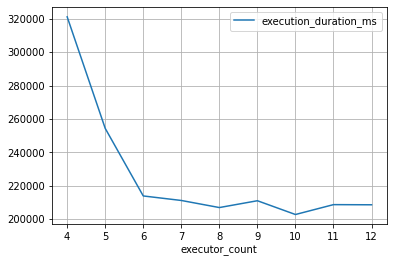

In [20]:
df = pd.DataFrame(durations)
df.set_index('executor_count')[['execution_duration_ms']].plot(grid=True)

# Observations

the performance seems to be capped at 210s on the TPC-H 100 dataset for the query 1. Indeed this query scans the lineitem table which represents \~70GB of data, and 70GB/210s=\~300MB/s which is the max burst read capacity of an EFS smaller than 1TB (https://docs.aws.amazon.com/efs/latest/ug/performance.html).

Thus we can safely conclude that the data read from EFS is the bottleneck here.